<a href="https://colab.research.google.com/github/huyhoang17/Colab_Temporary/blob/master/[Test]Triplet_Loss_Mnist_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# https://gist.github.com/huyhoang17/d67ca07483e4ddd4aa918a5aa9c6879c

In [0]:
try: # Python 2
    from cStringIO import StringIO as BytesIO
except: # Python 3
    from io import BytesIO
import PIL.Image
import IPython.display
import shutil
from math import sqrt

import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Lambda
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import defaultdict
from sklearn.datasets import fetch_mldata

In [0]:
def build_rainbow(n, curve=None):
    rgb = []
    width = 2 * np.pi
    for i in range(3):
        offset = -i * width / 3
        cur = np.cos(np.linspace(offset, offset + width, n))
        rgb.append(cur)
    rainbow = (1 + np.vstack(rgb)) / 2
    if curve:
        rainbow = curve(rainbow)
    rainbow = np.minimum(rainbow * 256, 255).astype(int)
    return rainbow.T

In [0]:
def map_range(x, in_min, in_max, out_min, out_max):
    return out_min + (out_max - out_min) * (x - in_min) / (in_max - in_min)

def plot_images(images, xy, blend=np.maximum, canvas_shape=(512,512), fill=0):    
    h,w = images.shape[1:3]
    if images.ndim == 4:
        canvas_shape = (canvas_shape[0], canvas_shape[1], images.shape[3])
    
    min_xy = np.amin(xy, 0)
    max_xy = np.amax(xy, 0)
    
    min_canvas = np.array((0, 0))
    max_canvas = np.array((canvas_shape[0] - h, canvas_shape[1] - w))
    
    canvas = np.full(canvas_shape, fill)
    for image, pos in zip(images, xy):
        x_off, y_off = map_range(pos, min_xy, max_xy, min_canvas, max_canvas).astype(int)
        sub_canvas = canvas[y_off:y_off+h, x_off:x_off+w]
        sub_image = image[:h, :w]
        canvas[y_off:y_off+h, x_off:x_off+w] = blend(sub_canvas, sub_image)

    return canvas

In [0]:
def show_array(a, fmt='png', filename=None, retina=False, zoom=None):
    if len(a.shape) == 1:
        n = len(a)
        side = int(sqrt(n))
        if (side * side) == n:
            a = a.reshape(side, side)
        else:
            raise ValueError('input is one-dimensional', a.shape)
    a = np.uint8(np.clip(a, 0, 255))
    image_data = BytesIO()
    PIL.Image.fromarray(a).save(image_data, fmt)
    if filename is None:
        height, width = a.shape[:2]
        if zoom is not None:
            width *= zoom
            height *= zoom
        IPython.display.display(IPython.display.Image(data=image_data.getvalue(),
                                                      width=width,
                                                      height=height,
                                                      retina=retina))
    else:
        with open(filename, 'wb') as f:
            image_data.seek(0)
            shutil.copyfileobj(image_data, f)

In [9]:
# load MNIST
mnist = fetch_mldata('MNIST original')
x = mnist.data.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
y = mnist.target.astype(np.int32)

# shuffle images and labels
indices = np.arange(len(x))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# verify the data is formatted correctly
print(x.dtype, x.min(), x.max(), x.shape)
print(y.dtype, y.min(), y.max(), y.shape)

# build colored versions
colors = build_rainbow(len(np.unique(y)))
colored_x = np.asarray([colors[cur_y] * cur_x for cur_x, cur_y in zip(x, y)])

float32 0.0 1.0 (70000, 28, 28, 1)
int32 0 9 (70000,)


In [0]:
def get_triples_indices(grouped, n):
    num_classes = len(grouped) 
    positive_labels = np.random.randint(0, num_classes, size=n)
    negative_labels = (np.random.randint(1, num_classes, size=n) + positive_labels) % num_classes
    triples_indices = []
    for positive_label, negative_label in zip(positive_labels, negative_labels):
        negative = np.random.choice(grouped[negative_label])
        positive_group = grouped[positive_label]
        m = len(positive_group)
        anchor_j = np.random.randint(0, m)
        anchor = positive_group[anchor_j]
        positive_j = (np.random.randint(1, m) + anchor_j) % m
        positive = positive_group[positive_j]
        triples_indices.append([anchor, positive, negative])
    return np.asarray(triples_indices)

def get_triples_data(x, grouped, n):
    indices = get_triples_indices(grouped, n)
    return x[indices[:,0]], x[indices[:,1]], x[indices[:,2]]

In [0]:
def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.mean(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.mean(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)

def build_model(input_shape):
    base_input = Input(input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(base_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(2, activation='linear')(x)
#     x = Lambda(lambda x: K.l2_normalize(x, axis=-1))(x) # force the embedding onto the surface of an n-sphere
    embedding_model = Model(base_input, x, name='embedding')
    
    anchor_input = Input(input_shape, name='anchor_input')
    positive_input = Input(input_shape, name='positive_input')
    negative_input = Input(input_shape, name='negative_input')
    
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    inputs = [anchor_input, positive_input, negative_input]
    outputs = [anchor_embedding, positive_embedding, negative_embedding]
    triplet_model = Model(inputs, outputs)
    triplet_model.add_loss(K.mean(triplet_loss(outputs)))
    triplet_model.compile(loss=None, optimizer='adam')

    return embedding_model, triplet_model

In [0]:
batch_size = 32
steps_per_epoch = 32
epochs = 100
plot_size = 1024

class Plotter(keras.callbacks.Callback):
    def __init__(self, embedding_model, x, images, plot_size):
        self.embedding_model = embedding_model
        self.x = x
        self.images = images
        self.plot_size = plot_size
    
    def on_epoch_end(self, epoch, logs={}):
        clear_output(wait=True)
        xy = self.embedding_model.predict(self.x[:self.plot_size])
        show_array(255-plot_images(self.images[:self.plot_size].squeeze(), xy))        

def triplet_generator(x, y, batch_size):
    grouped = defaultdict(list)
    for i, label in enumerate(y):
        grouped[label].append(i)
        
    while True:
        x_anchor, x_positive, x_negative = get_triples_data(x, grouped, batch_size)
        yield ({'anchor_input': x_anchor,
               'positive_input': x_positive,
               'negative_input': x_negative},
               None)

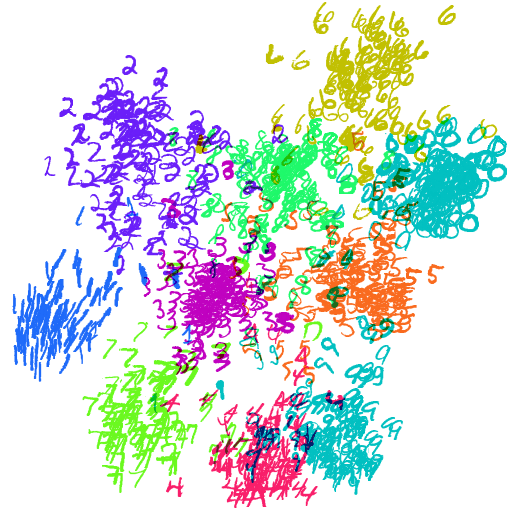

In [13]:
embedding_model, triplet_model = build_model((28, 28, 1))
plotter = Plotter(embedding_model, x, colored_x, plot_size)

try:
    history = triplet_model.fit_generator(triplet_generator(x, y, batch_size),
                                          steps_per_epoch=steps_per_epoch,
                                          epochs=epochs,
                                          verbose=0,
                                          callbacks=[plotter])
except KeyboardInterrupt:
    pass

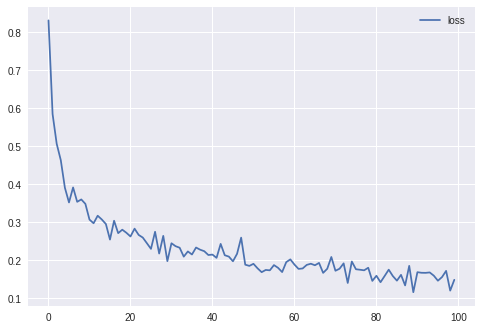

In [14]:
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

In [16]:
triplet_model.output

[<tf.Tensor 'embedding/dense_1/BiasAdd:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'embedding_1/dense_1/BiasAdd:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'embedding_2/dense_1/BiasAdd:0' shape=(?, 2) dtype=float32>]

In [20]:
triplet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
embedding (Model)               (None, 2)            22018       anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

In [19]:
embedding_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
__________